In [1]:
import utilities
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout , SpatialDropout2D
from tensorflow.keras.layers import AveragePooling2D, Activation
from tensorflow.keras.callbacks import History
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from  tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.regularizers import l1_l2, l1,l2
from tensorflow.keras.models import model_from_json
from sklearn.utils import class_weight
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import pyprog
import os

def set_gpus(gpus_number="1,2"):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = gpus_number
    
SETTINGS_DIR = os.path.dirname(os.path.realpath('__file__'))

speaker_name=input("Which speaker do you want to train/test? ")
train_set_path = SETTINGS_DIR+'/images/Dysarthric/Train/'+speaker_name
test_set_path = SETTINGS_DIR+"/images/Dysarthric/Test/"+speaker_name
dnn_file_name_structure = SETTINGS_DIR +"/Models/cnn_"+speaker_name+".json"
training_dynamics_path = SETTINGS_DIR+'/Training Performance/TrainingDynamics'+speaker_name+'.csv'
dnn_file_name_weights = SETTINGS_DIR +  "/Models/cnn_weight_"+speaker_name+".h5"

batch_size=256
image_input_size=(150,150)
vocab_size = utilities.get_no_folders_in_path(test_set_path)
print ("Vocabulary Size:",vocab_size)

def model_compile(model,lr=0.001):
    model.compile(loss=losses.categorical_crossentropy,
                          optimizer=optimizers.Adam(lr),
                          metrics=['accuracy'])
    
def get_model(hp):
    droprates=hp.Float('droprate', 0.2, 0.75, sampling='linear')
    learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')
    first_train=hp.Choice('first_train', values=['2','3','4','5','6'])
    model = FreezeLayers(droprates, load_model(learning_rate=learning_rate), top_unfrozen_layer_name="separable_conv2d_"+ first_train)

    return model

def predict_an_image(image_path, model):
    
    from tensorflow.keras.preprocessing import image

    test_image = image.load_img(image_path, target_size = image_input_size)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0) 

    y_pred = model.predict_classes(test_image,batch_size)[0]
    classes =training_set.class_indices
    for key, value in classes.items():
        if value==y_pred:
            break       

    pred_key=utilities.dictionary .index [ utilities.dictionary  ['FILE NAME'] == key ] 
    predicted_word=utilities.dictionary .iloc[pred_key[0],0]
    # Get true label
    true_key=true_key=utilities.file_to_index(image_path)
    true_word = utilities.dictionary .iloc[true_key,0]
    #print("Predicted:",predicted_word,", True:",true_word)
    return predicted_word, true_word

def read_epoch():
    if os.path.exists(training_dynamics_path):
        
        # First check the csv file has headres and add then if missing
        try:
            training_dynamics=pd.read_csv(training_dynamics_path)
            training_dynamics["Epoch"][len(training_dynamics)-1]
        except:
            df = pd.read_csv(training_dynamics_path, header=None, index_col=None)
            df.columns = columns=["","Epoch","TrainingLoss", "TrainingAccuracy","ValidationLoss","ValidationAccuracy"]
            df.to_csv(training_dynamics_path, index=False)
        training_dynamics=pd.read_csv(training_dynamics_path)               
        return training_dynamics["Epoch"][len(training_dynamics)-1]
        
    else:
        return 0

def load_model(learning_rate=0.001):
    # Loading the CNN
    json_file = open(dnn_file_name_structure, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(dnn_file_name_weights)
    print(learning_rate)
    model_compile(model,learning_rate)
    return model

def save_model(model,is_max_val_inclluded=False,max_val=None, ep=None):
    # Save/overwrite the model
    if (is_max_val_inclluded):
        json_file_name = SETTINGS_DIR+"/Models/cnn_"+speaker_name+"_"+str(max_val)+"_"+str(ep)+".json"
        wights_file_name = SETTINGS_DIR+"/Models/cnn_weight_"+speaker_name+"_"+str(max_val)+"_"+str(ep)+".h5"
        # Delete previously stored models for this speaker
        for directory, s, files in os.walk(SETTINGS_DIR+"/Models/"):
            for f in files:
                if speaker_name in f:
                    file_path=directory+"/"+f
                    os.remove(file_path)
    else:
        json_file_name = dnn_file_name_structure
        wights_file_name = dnn_file_name_weights
    
    model_json = model.to_json()
    with open(json_file_name, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(wights_file_name)
    
def save_training_dynamics(epoch,history,with_header=False):
    training_dynamics=pd.DataFrame(
        data = [ [epoch, history.history['loss'][0] ,  history.history['accuracy'][0],  
                history.history['val_loss'][0],  history.history['val_accuracy'][0] ]],
        columns=["Epoch","TrainingLoss", "TrainingAccuracy","ValidationLoss","ValidationAccuracy"]
    )
    if (with_header):
        with open(training_dynamics_path, 'a') as csv_file:
            training_dynamics.to_csv(csv_file, header=True)
    else:
        with open(training_dynamics_path, 'a') as csv_file:
            training_dynamics.to_csv(csv_file, header=False)
            
def visualize_training():
    import matplotlib.pyplot as plt
    if (os.path.isfile(training_dynamics_path) == False ):
        print ("Training dynamics file is not found.")
        return
    try:
        training_dynamics=pd.read_csv(training_dynamics_path)
        loss_values = training_dynamics["TrainingLoss"]
        val_loss_values = training_dynamics["ValidationLoss"]
        epochs = range(1, len (training_dynamics['Epoch'])+1)
        plt.plot(epochs, loss_values, 'g', label='Training loss')
        plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        # Ploting Accuracy
        loss_values = training_dynamics["TrainingAccuracy"]
        val_loss_values = training_dynamics["ValidationAccuracy"]
        epochs = range(1, len (training_dynamics['Epoch'])+1)
        plt.plot(epochs, loss_values, 'g', label='Training loss')
        plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
     
    except:
        df = pd.read_csv(training_dynamics_path, header=None, index_col=None)
        df.columns = ["","Epoch","TrainingLoss", "TrainingAccuracy","ValidationLoss","ValidationAccuracy"]
        df.to_csv(training_dynamics_path, index=False)
        visualize_training()
    
def get_train_test_sets():
        from tensorflow.keras.preprocessing.image import ImageDataGenerator
        
        # https://fairyonice.github.io/Learn-about-ImageDataGenerator.html
        train_datagen = ImageDataGenerator(
                    rescale=1./255,
            width_shift_range=0.30,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest',
            horizontal_flip=False)
        
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        # If shuffle=False then the validation results will be different from classifier.predict_generator()
        print ("Setting training date...")
        training_set = train_datagen.flow_from_directory(
            train_set_path,
            target_size=image_input_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True)
        
        print ("Setting testing date...")
        test_set = test_datagen.flow_from_directory(
           test_set_path,
            target_size=image_input_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False)
        return training_set, test_set
    
def test_generator(test_set_generator):
    steps=test_set_generator.samples/batch_size
    model = load_model()

    y_pred = model.evaluate_generator(test_set_generator, steps = steps, verbose = 1)
    y_test = test_set_generator.classes
    correct_classifications=0
    for pred,label in zip(y_pred, y_test):
        if pred.argmax()==label:
            correct_classifications+=1
    print ("Loss:", y_pred[0])
    print ("Acuracy:", y_pred[1] *100,"%")
    return 

def manual_testing():
    model = load_model() 
    #test_path = SETTINGS_DIR+"/images/Control/Test"
    #test_path = SETTINGS_DIR+"/images/Dysarthric/Test/F05"
    #test_path = SETTINGS_DIR+"/images/Dysarthric/Test/M06"
    #test_path = SETTINGS_DIR+"/images/Dysarthric/Test/M10"
    #test_path = SETTINGS_DIR+"/images/Control/Test"
    test_path=test_set_path
    
    correct_classifications=0
    i=0
    prog = pyprog.ProgressBar("Predicting ", " Done", utilities.get_no_files_in_path(test_path))
    # Show the initial status
    prog.update()
    no_processed=i
    for directory, s, files in os.walk(test_path):
            for f in files:
                file_path=directory+"/"+f
                if ("jpg" in f):                
                    predicted_word, true_word = predict_an_image(file_path,model)
                    #print (predicted_word,true_word)
                    if (predicted_word==true_word):
                        correct_classifications+=1
                    i+=1
                    prog.set_stat(i)
                    prog.update()

    prog.end()
    print ("Testing acuracy:", correct_classifications/i *100,"%")
    
def train(ideal_loss=0.01, is_dnn_structure_changned=False, learning_rate=0.001, max_epoch=50, enabled_trasfer_learning=False):
        
        # Check if speaker_name is set
        if (speaker_name==""):
            print ("Please set speaker_name and try again.")
            return
            
        is_new_dnn=False
        
        history = History()
        
        print("=================================================")
        
        if (os.path.isfile(dnn_file_name_structure) and
                (os.path.isfile(dnn_file_name_weights)) and 
                (is_dnn_structure_changned == False)):
            # load the previosly trained DNN
            if (enabled_trasfer_learning):
                # Enable Transfer Learning
                print ("Transfer learning is enabled.")
                model = FreezeLayers(load_model(learning_rate=learning_rate),
                                     top_unfrozen_layer_name="separable_conv2d_3" ) 
            else:
                print ("Transer learning is disabled.")
                model = load_model(learning_rate=learning_rate)
            print("CNN is loaded.")
        else:
            # Create a new model
            model =  get_model()                    
            print("CNN is created")
            # Erase the training_dynamic_csv file
            if os.path.exists(training_dynamics_path):
                os.remove(training_dynamics_path)
            is_new_dnn=True
            model_compile(model)
        
        ep= read_epoch()+1
        PringFrozenLayers(model)
        history=model.fit(
            training_set,
            steps_per_epoch=training_set.samples/batch_size, epochs=1,                            
                             validation_data=test_set,
                             validation_steps=test_set.samples/batch_size,
                             workers=10, 
                             max_queue_size=10)
        
        save_training_dynamics(ep,history,with_header=is_new_dnn)
       
        max_val = history.history['val_accuracy'][0]
        
        while (history.history['loss'][0] >= ideal_loss):
            print("Epoch", ep)
            history=model.fit(
            training_set,
            steps_per_epoch=training_set.samples/batch_size,epochs=1,
                             validation_data=test_set,
                             validation_steps=test_set.samples/batch_size,
                             workers=10,
                             max_queue_size=10)

            # Save the max model, if any            
            if (history.history['val_accuracy'][0]>max_val):
                max_val= history.history['val_accuracy'][0]
                save_model(model=model,is_max_val_inclluded=True,max_val=max_val,ep=ep)
             
            # Save/overwrite the model
            save_model(model)
               
            ep += 1
            save_training_dynamics(ep,history,with_header=False)        

            # stop the traning if certain accuracy is reached
            #if (ep%10==0):
                #manual_testing()   
            #if   (history.history['val_accuracy'][0]>0.92):
              #  break
            if (history.history['loss'][0]<ideal_loss):
                   break
            
            if (ep > max_epoch):
                break

        return history
    
    # Transfer learning: freeze top layers but unfreeze all layers below the given layer   
def FreezeLayers(droprate, model, top_unfrozen_layer_name):
    
    model.trainable=True
    set_trainable = False
    for layer in model.layers:
        # Increase dropout rate
        if "dropout" in layer.name:
            layer.rate=droprate
            print (layer.name,"dropout rate updated to",layer.rate)
        if (layer.name==top_unfrozen_layer_name):
            set_trainable=True

        if (set_trainable):
            print (layer.name," NOT FREEZED")
            layer.trainable=True
        else:
            print (layer.name," FREEZED")
            layer.trainable=False
        #if (layer.name=="dense_1"):
            #layer.trainable = False
    #model = add_new_dense(model)
    model_compile(model)
    return model

# add a new dense layer
def add_new_dense(model):
    new_model=Sequential()

    for layer in model.layers[:-1]:
        layer.name=layer.name+"_old"
        new_model.add(layer)
    new_model.add(Dense(units = 1024, activation='relu' ))
    new_model.add(Dropout(0.5))
    new_model.add(Dense (units=vocab_size, activation='softmax' ))
    return new_model

def PringFrozenLayers(model):
     for layer in model.layers:
            print ("Layer:",layer.name, "Frozen:",not layer.trainable)
            
def training_restart_initalize():
    import shutil
    shutil.copyfile(SETTINGS_DIR+"/Models/cnn_control.json", dnn_file_name_structure)
    shutil.copyfile(SETTINGS_DIR+"/Models/cnn_weight_control.h5", dnn_file_name_weights)
    if (os.path.isfile(training_dynamics_path)):
        os.remove(training_dynamics_path)
    print ("Ready for training...")

# Load X and y
training_set, test_set =get_train_test_sets()


!find '.' -name '*.ipynb_checkpoints' -exec rm -r {} +

Which speaker do you want to train/test? M12
Vocabulary Size: 155
Setting training date...
Found 930 images belonging to 155 classes.
Setting testing date...
Found 465 images belonging to 155 classes.


In [2]:
# Enable this if you want to train the model for this speaker from scracth. 
# Otherwise, the previously trained model is continued training.
# This loads the base, control model.
training_restart_initalize()
set_gpus("2")

Ready for training...


In [4]:
# Train
sv.set_gpus("2")
sv.train(is_dnn_structure_changned= False, 
         enabled_trasfer_learning=True,
         learning_rate=0.0001,
         max_epoch=50000)

Transfer learning is enabled.
0.0001
separable_conv2d  FREEZED
spatial_dropout2d dropout rate updated to 0.5
spatial_dropout2d  FREEZED
batch_normalization  FREEZED
max_pooling2d  FREEZED
separable_conv2d_1  FREEZED
spatial_dropout2d_1 dropout rate updated to 0.5
spatial_dropout2d_1  FREEZED
batch_normalization_1  FREEZED
separable_conv2d_2  FREEZED
spatial_dropout2d_2 dropout rate updated to 0.5
spatial_dropout2d_2  FREEZED
batch_normalization_2  FREEZED
max_pooling2d_1  FREEZED
separable_conv2d_3  FREEZED
spatial_dropout2d_3 dropout rate updated to 0.5
spatial_dropout2d_3  FREEZED
batch_normalization_3  FREEZED
separable_conv2d_4  NOT FREEZED
spatial_dropout2d_4 dropout rate updated to 0.5
spatial_dropout2d_4  NOT FREEZED
max_pooling2d_2  NOT FREEZED
dropout dropout rate updated to 0.5
dropout  NOT FREEZED
flatten  NOT FREEZED
dense  NOT FREEZED
CNN is loaded.
Layer: separable_conv2d Frozen: True
Layer: spatial_dropout2d Frozen: True
Layer: batch_normalization Frozen: True
Layer: max

Epoch 495
3/3 [==============================] - 3s 590ms/step - loss: 2.7882 - accuracy: 0.7097 - val_loss: 3.7300 - val_accuracy: 0.5054
Epoch 496
3/3 [==============================] - 3s 618ms/step - loss: 2.7216 - accuracy: 0.7161 - val_loss: 3.7459 - val_accuracy: 0.5247
Epoch 497
3/3 [==============================] - 3s 609ms/step - loss: 2.7576 - accuracy: 0.7194 - val_loss: 3.7531 - val_accuracy: 0.5226
Epoch 498
3/3 [==============================] - 3s 601ms/step - loss: 2.7254 - accuracy: 0.7108 - val_loss: 3.7662 - val_accuracy: 0.5312
Epoch 499
3/3 [==============================] - 3s 775ms/step - loss: 2.7486 - accuracy: 0.7086 - val_loss: 3.7458 - val_accuracy: 0.5419
Epoch 500
3/3 [==============================] - 3s 612ms/step - loss: 2.7570 - accuracy: 0.7226 - val_loss: 3.7160 - val_accuracy: 0.5462
Epoch 501
3/3 [==============================] - 3s 601ms/step - loss: 2.6732 - accuracy: 0.7387 - val_loss: 3.7037 - val_accuracy: 0.5570
Epoch 502
3/3 [============

Epoch 554
3/3 [==============================] - 3s 706ms/step - loss: 2.8216 - accuracy: 0.7312 - val_loss: 3.8347 - val_accuracy: 0.5398
Epoch 555
3/3 [==============================] - 3s 744ms/step - loss: 2.9498 - accuracy: 0.7129 - val_loss: 3.8355 - val_accuracy: 0.5419
Epoch 556
3/3 [==============================] - 3s 612ms/step - loss: 2.8174 - accuracy: 0.7376 - val_loss: 3.8296 - val_accuracy: 0.5419
Epoch 557
3/3 [==============================] - 3s 572ms/step - loss: 2.8313 - accuracy: 0.7387 - val_loss: 3.8347 - val_accuracy: 0.5527
Epoch 558
3/3 [==============================] - 3s 579ms/step - loss: 2.7765 - accuracy: 0.7591 - val_loss: 3.8441 - val_accuracy: 0.5419
Epoch 559
3/3 [==============================] - 3s 555ms/step - loss: 2.6827 - accuracy: 0.7656 - val_loss: 3.8699 - val_accuracy: 0.5376
Epoch 560
3/3 [==============================] - 3s 780ms/step - loss: 2.8089 - accuracy: 0.7376 - val_loss: 3.8910 - val_accuracy: 0.5376
Epoch 561
3/3 [============

Epoch 613
3/3 [==============================] - 3s 600ms/step - loss: 2.8146 - accuracy: 0.7430 - val_loss: 4.0030 - val_accuracy: 0.5355
Epoch 614
3/3 [==============================] - 3s 630ms/step - loss: 2.6805 - accuracy: 0.7720 - val_loss: 4.0146 - val_accuracy: 0.5247
Epoch 615
3/3 [==============================] - 3s 564ms/step - loss: 2.8083 - accuracy: 0.7527 - val_loss: 4.0273 - val_accuracy: 0.5161
Epoch 616
3/3 [==============================] - 3s 599ms/step - loss: 2.7401 - accuracy: 0.7516 - val_loss: 4.0418 - val_accuracy: 0.5011
Epoch 617
3/3 [==============================] - 3s 614ms/step - loss: 2.7887 - accuracy: 0.7505 - val_loss: 4.0600 - val_accuracy: 0.5075
Epoch 618
3/3 [==============================] - 3s 607ms/step - loss: 2.7542 - accuracy: 0.7473 - val_loss: 4.0449 - val_accuracy: 0.5140
Epoch 619
3/3 [==============================] - 3s 750ms/step - loss: 2.8585 - accuracy: 0.7387 - val_loss: 4.0102 - val_accuracy: 0.5226
Epoch 620
3/3 [============

Epoch 672
3/3 [==============================] - 3s 614ms/step - loss: 2.7399 - accuracy: 0.7591 - val_loss: 4.0791 - val_accuracy: 0.4989
Epoch 673
3/3 [==============================] - 3s 575ms/step - loss: 2.6467 - accuracy: 0.7839 - val_loss: 4.0941 - val_accuracy: 0.5097
Epoch 674
3/3 [==============================] - 3s 579ms/step - loss: 2.7010 - accuracy: 0.7828 - val_loss: 4.1011 - val_accuracy: 0.5075
Epoch 675
3/3 [==============================] - 3s 573ms/step - loss: 2.7138 - accuracy: 0.7559 - val_loss: 4.0934 - val_accuracy: 0.5075
Epoch 676
3/3 [==============================] - 3s 563ms/step - loss: 2.6863 - accuracy: 0.7882 - val_loss: 4.0800 - val_accuracy: 0.5054
Epoch 677
3/3 [==============================] - 3s 613ms/step - loss: 2.7230 - accuracy: 0.7688 - val_loss: 4.0622 - val_accuracy: 0.5054
Epoch 678
3/3 [==============================] - 3s 755ms/step - loss: 2.6912 - accuracy: 0.7828 - val_loss: 4.0476 - val_accuracy: 0.5226
Epoch 679
3/3 [============

Epoch 731
3/3 [==============================] - 3s 726ms/step - loss: 2.6199 - accuracy: 0.7957 - val_loss: 4.1285 - val_accuracy: 0.5140
Epoch 732
3/3 [==============================] - 3s 742ms/step - loss: 2.7316 - accuracy: 0.7656 - val_loss: 4.1104 - val_accuracy: 0.5290
Epoch 733
3/3 [==============================] - 3s 712ms/step - loss: 2.7083 - accuracy: 0.7624 - val_loss: 4.1065 - val_accuracy: 0.5204
Epoch 734
3/3 [==============================] - 3s 624ms/step - loss: 2.6687 - accuracy: 0.7796 - val_loss: 4.1168 - val_accuracy: 0.5097
Epoch 735
3/3 [==============================] - 3s 613ms/step - loss: 2.5717 - accuracy: 0.7871 - val_loss: 4.1243 - val_accuracy: 0.5140
Epoch 736
3/3 [==============================] - 3s 705ms/step - loss: 2.8015 - accuracy: 0.7452 - val_loss: 4.1228 - val_accuracy: 0.5204
Epoch 737
3/3 [==============================] - 3s 581ms/step - loss: 2.5826 - accuracy: 0.7978 - val_loss: 4.1365 - val_accuracy: 0.5290
Epoch 738
3/3 [============

Epoch 790
3/3 [==============================] - 3s 599ms/step - loss: 2.5466 - accuracy: 0.8032 - val_loss: 4.1897 - val_accuracy: 0.5204
Epoch 791
3/3 [==============================] - 3s 559ms/step - loss: 2.6069 - accuracy: 0.7710 - val_loss: 4.1934 - val_accuracy: 0.5247
Epoch 792
3/3 [==============================] - 3s 623ms/step - loss: 2.5318 - accuracy: 0.7978 - val_loss: 4.1888 - val_accuracy: 0.5204
Epoch 793
3/3 [==============================] - 3s 553ms/step - loss: 2.5165 - accuracy: 0.8118 - val_loss: 4.1845 - val_accuracy: 0.5376
Epoch 794
3/3 [==============================] - 3s 599ms/step - loss: 2.5399 - accuracy: 0.7903 - val_loss: 4.1801 - val_accuracy: 0.5247
Epoch 795
3/3 [==============================] - 3s 613ms/step - loss: 2.5449 - accuracy: 0.7892 - val_loss: 4.1894 - val_accuracy: 0.5333
Epoch 796
3/3 [==============================] - 3s 604ms/step - loss: 2.5133 - accuracy: 0.8032 - val_loss: 4.1883 - val_accuracy: 0.5312
Epoch 797
3/3 [============

Epoch 849
3/3 [==============================] - 3s 581ms/step - loss: 2.4158 - accuracy: 0.8161 - val_loss: 4.0231 - val_accuracy: 0.5290
Epoch 850
3/3 [==============================] - 3s 627ms/step - loss: 2.4745 - accuracy: 0.7946 - val_loss: 4.0421 - val_accuracy: 0.5247
Epoch 851
3/3 [==============================] - 3s 619ms/step - loss: 2.5041 - accuracy: 0.8054 - val_loss: 4.0755 - val_accuracy: 0.5312
Epoch 852
3/3 [==============================] - 3s 758ms/step - loss: 2.4912 - accuracy: 0.8108 - val_loss: 4.1241 - val_accuracy: 0.5333
Epoch 853
3/3 [==============================] - 3s 715ms/step - loss: 2.5516 - accuracy: 0.7828 - val_loss: 4.1297 - val_accuracy: 0.5355
Epoch 854
3/3 [==============================] - 3s 628ms/step - loss: 2.5230 - accuracy: 0.7946 - val_loss: 4.1301 - val_accuracy: 0.5398
Epoch 855
3/3 [==============================] - 3s 620ms/step - loss: 2.4807 - accuracy: 0.8011 - val_loss: 4.1095 - val_accuracy: 0.5333
Epoch 856
3/3 [============

Epoch 908
3/3 [==============================] - 3s 621ms/step - loss: 2.4192 - accuracy: 0.8247 - val_loss: 4.3292 - val_accuracy: 0.5183
Epoch 909
3/3 [==============================] - 3s 588ms/step - loss: 2.4601 - accuracy: 0.8054 - val_loss: 4.3217 - val_accuracy: 0.5269
Epoch 910
3/3 [==============================] - 3s 723ms/step - loss: 2.4614 - accuracy: 0.8075 - val_loss: 4.2865 - val_accuracy: 0.5226
Epoch 911
3/3 [==============================] - 3s 790ms/step - loss: 2.4770 - accuracy: 0.8226 - val_loss: 4.2547 - val_accuracy: 0.5333
Epoch 912
3/3 [==============================] - 3s 612ms/step - loss: 2.4944 - accuracy: 0.7903 - val_loss: 4.2262 - val_accuracy: 0.5419
Epoch 913
3/3 [==============================] - 3s 598ms/step - loss: 2.5147 - accuracy: 0.7989 - val_loss: 4.1971 - val_accuracy: 0.5376
Epoch 914
3/3 [==============================] - 3s 610ms/step - loss: 2.5137 - accuracy: 0.7914 - val_loss: 4.1561 - val_accuracy: 0.5118
Epoch 915
3/3 [============

Epoch 967
3/3 [==============================] - 3s 711ms/step - loss: 2.4154 - accuracy: 0.8043 - val_loss: 4.1469 - val_accuracy: 0.5161
Epoch 968
3/3 [==============================] - 3s 640ms/step - loss: 2.4889 - accuracy: 0.7796 - val_loss: 4.1625 - val_accuracy: 0.5140
Epoch 969
3/3 [==============================] - 3s 580ms/step - loss: 2.3705 - accuracy: 0.8086 - val_loss: 4.1808 - val_accuracy: 0.5140
Epoch 970
3/3 [==============================] - 3s 640ms/step - loss: 2.3856 - accuracy: 0.8419 - val_loss: 4.1850 - val_accuracy: 0.5161
Epoch 971
3/3 [==============================] - 3s 617ms/step - loss: 2.4723 - accuracy: 0.7968 - val_loss: 4.1926 - val_accuracy: 0.5075
Epoch 972
3/3 [==============================] - 3s 623ms/step - loss: 2.4727 - accuracy: 0.8086 - val_loss: 4.1844 - val_accuracy: 0.5118
Epoch 973
3/3 [==============================] - 3s 579ms/step - loss: 2.4467 - accuracy: 0.7957 - val_loss: 4.1757 - val_accuracy: 0.5269
Epoch 974
3/3 [============

Epoch 1026
3/3 [==============================] - 3s 561ms/step - loss: 2.4697 - accuracy: 0.7946 - val_loss: 4.0791 - val_accuracy: 0.5140
Epoch 1027
3/3 [==============================] - 3s 745ms/step - loss: 2.4908 - accuracy: 0.7957 - val_loss: 4.0903 - val_accuracy: 0.5204
Epoch 1028
3/3 [==============================] - 3s 612ms/step - loss: 2.3975 - accuracy: 0.8075 - val_loss: 4.1107 - val_accuracy: 0.5204
Epoch 1029
3/3 [==============================] - 3s 622ms/step - loss: 2.4312 - accuracy: 0.8065 - val_loss: 4.1268 - val_accuracy: 0.5183
Epoch 1030
3/3 [==============================] - 3s 605ms/step - loss: 2.4217 - accuracy: 0.8129 - val_loss: 4.1229 - val_accuracy: 0.5075
Epoch 1031
3/3 [==============================] - 3s 610ms/step - loss: 2.4093 - accuracy: 0.8151 - val_loss: 4.1264 - val_accuracy: 0.4989
Epoch 1032
3/3 [==============================] - 3s 559ms/step - loss: 2.3426 - accuracy: 0.8118 - val_loss: 4.1074 - val_accuracy: 0.5075
Epoch 1033
3/3 [====

3/3 [==============================] - 3s 618ms/step - loss: 2.3291 - accuracy: 0.8323 - val_loss: 4.1476 - val_accuracy: 0.5118
Epoch 1143
3/3 [==============================] - 3s 623ms/step - loss: 2.2967 - accuracy: 0.8194 - val_loss: 4.1506 - val_accuracy: 0.5097
Epoch 1144
3/3 [==============================] - 3s 604ms/step - loss: 2.3688 - accuracy: 0.8129 - val_loss: 4.1631 - val_accuracy: 0.5032
Epoch 1145
3/3 [==============================] - 3s 612ms/step - loss: 2.3390 - accuracy: 0.8301 - val_loss: 4.1746 - val_accuracy: 0.5075
Epoch 1146
3/3 [==============================] - 3s 738ms/step - loss: 2.4125 - accuracy: 0.8108 - val_loss: 4.1766 - val_accuracy: 0.5011
Epoch 1147
3/3 [==============================] - 3s 570ms/step - loss: 2.3406 - accuracy: 0.8237 - val_loss: 4.1421 - val_accuracy: 0.5097
Epoch 1148
3/3 [==============================] - 3s 744ms/step - loss: 2.3874 - accuracy: 0.8108 - val_loss: 4.1049 - val_accuracy: 0.5204
Epoch 1149
3/3 [===============

3/3 [==============================] - 3s 575ms/step - loss: 2.3265 - accuracy: 0.8183 - val_loss: 4.2422 - val_accuracy: 0.5247
Epoch 1259
3/3 [==============================] - 3s 600ms/step - loss: 2.3918 - accuracy: 0.8194 - val_loss: 4.2405 - val_accuracy: 0.5226
Epoch 1260
3/3 [==============================] - 3s 562ms/step - loss: 2.3989 - accuracy: 0.8204 - val_loss: 4.2207 - val_accuracy: 0.5183
Epoch 1261
3/3 [==============================] - 3s 559ms/step - loss: 2.2903 - accuracy: 0.8226 - val_loss: 4.2024 - val_accuracy: 0.5183
Epoch 1262
3/3 [==============================] - 3s 602ms/step - loss: 2.3326 - accuracy: 0.8215 - val_loss: 4.2013 - val_accuracy: 0.5226
Epoch 1263
3/3 [==============================] - 3s 761ms/step - loss: 2.3169 - accuracy: 0.8280 - val_loss: 4.2404 - val_accuracy: 0.5269
Epoch 1264
3/3 [==============================] - 3s 600ms/step - loss: 2.3882 - accuracy: 0.8258 - val_loss: 4.2692 - val_accuracy: 0.5075
Epoch 1265
3/3 [===============

3/3 [==============================] - 3s 627ms/step - loss: 2.3092 - accuracy: 0.8215 - val_loss: 4.1261 - val_accuracy: 0.5226
Epoch 1375
3/3 [==============================] - 3s 614ms/step - loss: 2.2744 - accuracy: 0.8376 - val_loss: 4.1497 - val_accuracy: 0.5140
Epoch 1376
3/3 [==============================] - 3s 602ms/step - loss: 2.3496 - accuracy: 0.8290 - val_loss: 4.1396 - val_accuracy: 0.5183
Epoch 1377
3/3 [==============================] - 3s 623ms/step - loss: 2.2865 - accuracy: 0.8280 - val_loss: 4.1354 - val_accuracy: 0.5204
Epoch 1378
3/3 [==============================] - 3s 620ms/step - loss: 2.2568 - accuracy: 0.8258 - val_loss: 4.1063 - val_accuracy: 0.5462
Epoch 1379
3/3 [==============================] - 3s 718ms/step - loss: 2.3945 - accuracy: 0.8086 - val_loss: 4.0926 - val_accuracy: 0.5505
Epoch 1380
3/3 [==============================] - 3s 567ms/step - loss: 2.3215 - accuracy: 0.8366 - val_loss: 4.0780 - val_accuracy: 0.5527
Epoch 1381
3/3 [===============

3/3 [==============================] - 3s 607ms/step - loss: 2.3452 - accuracy: 0.8237 - val_loss: 4.2397 - val_accuracy: 0.5247
Epoch 1491
3/3 [==============================] - 3s 684ms/step - loss: 2.2760 - accuracy: 0.8409 - val_loss: 4.2172 - val_accuracy: 0.5312
Epoch 1492
3/3 [==============================] - 3s 592ms/step - loss: 2.4255 - accuracy: 0.8204 - val_loss: 4.1760 - val_accuracy: 0.5441
Epoch 1493
3/3 [==============================] - 3s 584ms/step - loss: 2.3471 - accuracy: 0.8237 - val_loss: 4.1354 - val_accuracy: 0.5419
Epoch 1494
3/3 [==============================] - 3s 561ms/step - loss: 2.3460 - accuracy: 0.8140 - val_loss: 4.1085 - val_accuracy: 0.5398
Epoch 1495
3/3 [==============================] - 3s 587ms/step - loss: 2.3749 - accuracy: 0.8194 - val_loss: 4.1083 - val_accuracy: 0.5269
Epoch 1496
3/3 [==============================] - 3s 713ms/step - loss: 2.3891 - accuracy: 0.8226 - val_loss: 4.1172 - val_accuracy: 0.5419
Epoch 1497
3/3 [===============

KeyboardInterrupt: 

In [3]:
tuner_search=RandomSearch(get_model,
                          objective='val_accuracy',
                          max_trials=55,directory='tuner_model_M12',
                          project_name="dyser_M12_Resnet")

INFO:tensorflow:Reloading Oracle from existing project tuner_model_M12/dyser_M12_Resnet/oracle.json
0.0001
input_1  FREEZED
separable_conv2d  FREEZED
spatial_dropout2d dropout rate updated to 0.2
spatial_dropout2d  FREEZED
batch_normalization  FREEZED
activation  FREEZED
max_pooling2d  FREEZED
separable_conv2d_1  FREEZED
spatial_dropout2d_1 dropout rate updated to 0.2
spatial_dropout2d_1  FREEZED
batch_normalization_1  FREEZED
activation_1  FREEZED
separable_conv2d_2  NOT FREEZED
spatial_dropout2d_2 dropout rate updated to 0.2
spatial_dropout2d_2  NOT FREEZED
conv2d  NOT FREEZED
batch_normalization_2  NOT FREEZED
batch_normalization_3  NOT FREEZED
add  NOT FREEZED
activation_2  NOT FREEZED
max_pooling2d_1  NOT FREEZED
separable_conv2d_3  NOT FREEZED
spatial_dropout2d_3 dropout rate updated to 0.2
spatial_dropout2d_3  NOT FREEZED
batch_normalization_4  NOT FREEZED
activation_3  NOT FREEZED
separable_conv2d_4  NOT FREEZED
spatial_dropout2d_4 dropout rate updated to 0.2
spatial_dropout2d_

In [4]:
tuner_search.reload()
model=tuner_search.get_best_models(num_models=1)[0]
best_hps=tuner_search.get_best_hyperparameters(num_trials=1)[0]
print('best hyper parameters are:')
print('droprate',best_hps.get('droprate'))
print('first_train',best_hps.get('first_train'))
print('lr',best_hps.get('lr'))

0.0004001857503058816
input_1  FREEZED
separable_conv2d  FREEZED
spatial_dropout2d dropout rate updated to 0.25688887976963115
spatial_dropout2d  FREEZED
batch_normalization  FREEZED
activation  FREEZED
max_pooling2d  FREEZED
separable_conv2d_1  FREEZED
spatial_dropout2d_1 dropout rate updated to 0.25688887976963115
spatial_dropout2d_1  FREEZED
batch_normalization_1  FREEZED
activation_1  FREEZED
separable_conv2d_2  NOT FREEZED
spatial_dropout2d_2 dropout rate updated to 0.25688887976963115
spatial_dropout2d_2  NOT FREEZED
conv2d  NOT FREEZED
batch_normalization_2  NOT FREEZED
batch_normalization_3  NOT FREEZED
add  NOT FREEZED
activation_2  NOT FREEZED
max_pooling2d_1  NOT FREEZED
separable_conv2d_3  NOT FREEZED
spatial_dropout2d_3 dropout rate updated to 0.25688887976963115
spatial_dropout2d_3  NOT FREEZED
batch_normalization_4  NOT FREEZED
activation_3  NOT FREEZED
separable_conv2d_4  NOT FREEZED
spatial_dropout2d_4 dropout rate updated to 0.25688887976963115
spatial_dropout2d_4  NO

In [5]:
tuner_search.search_space_summary()

Search space summary
Default search space size: 3
droprate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.75, 'step': None, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
first_train (Choice)
{'default': '2', 'conditions': [], 'values': ['2', '3', '4', '5', '6'], 'ordered': False}


In [ ]:
tuner_search.search(training_set,epochs=95,
                    steps_per_epoch=training_set.samples/batch_size,
                    validation_data=test_set,
                    validation_steps=test_set.samples/batch_size,
                    workers=10,
                    max_queue_size=10
                   )

Trial 7 Complete [00h 08m 21s]
val_accuracy: 0.47526881098747253

Best val_accuracy So Far: 0.49677419662475586
Total elapsed time: 00h 56m 32s

Search: Running Trial #8

Hyperparameter    |Value             |Best Value So Far 
droprate          |0.29266           |0.25689           
lr                |0.00017803        |0.00040019        
first_train       |2                 |2                 

0.00017803406703647428
input_1  FREEZED
separable_conv2d  FREEZED
spatial_dropout2d dropout rate updated to 0.2926635254173455
spatial_dropout2d  FREEZED
batch_normalization  FREEZED
activation  FREEZED
max_pooling2d  FREEZED
separable_conv2d_1  FREEZED
spatial_dropout2d_1 dropout rate updated to 0.2926635254173455
spatial_dropout2d_1  FREEZED
batch_normalization_1  FREEZED
activation_1  FREEZED
separable_conv2d_2  NOT FREEZED
spatial_dropout2d_2 dropout rate updated to 0.2926635254173455
spatial_dropout2d_2  NOT FREEZED
conv2d  NOT FREEZED
batch_normalization_2  NOT FREEZED
batch_normalizatio

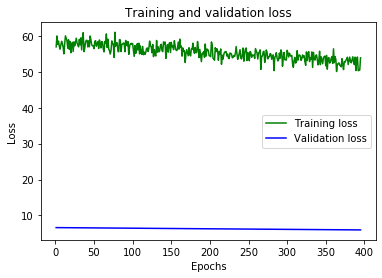

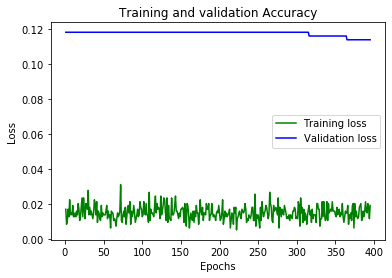

In [4]:
sv.visualize_training()

In [ ]:
# Test
sv.set_gpus("1")
sv.test_generator(sv.test_set)